# Part 1 - Text Adventure Games
## Overview
*Text Adventure Games* are games in which the player interacts with a rich world only through text. Text adventure games predate computers with graphics. However, in many ways they are more complex than conventional video games because they can involve complicated interactions (e.g., "build a rope bridge") that require a fair amount of imagination. Indeed, text adventure games are used as [research testbeds](https://arxiv.org/abs/1909.05398) for natural language processing agents.

The canonical text adventure game is [Zork](https://en.wikipedia.org/wiki/Zork), in which the player discover an abandoned underworld realm full of treasure. You can find online playable versions.

A text game is made up of individual locations--also called "rooms", though they need not be indoor enclosed spaces as the term might imply. The agent can move between rooms and interact with objects by typing in short commands like "move north" and "take lamp".

In this assignment, we will use a special package that implements text worlds for testing agents: [TextWorld-Express](https://github.com/cognitiveailab/TextWorldExpress). Textworld-Express simplifies text worlds in a few ways: it uses a reduced set of text commands, and rooms laid out in a grid.
TextWorld-Express also implements a few different game objectives, such as cooking, and searching for coins.
TextWorld-Express generates world configurations, so we will need to implement algorithms that are able to complete different game objectives in different world configurations.

In this part of the assignment, our agents will play two different games:
- **Coin Game**: a game in which the agent must search for and pick up a single coin.
- **Map Reader**: a game in which the agent must find a coin and return it to a box at the starting location.

We will be implementing various search algorithms towards these games to help the agent succeed!

## Important Notes and Guidelines
- You are **only** allowed to use a restricted set of libraries for this assignment. All packages that come with the default Python installation are permitted, as well as any imports we have already provided for you. You may not use any other libraries than the ones we have provided. If you attempt to use other libraries, the autograder will not be able to run your code.
- In the Map Reader game, you must use a single search loop (you cannot run a search to the coin and then a separate search to the box). You cannot write specialized code for handling the Map Reader game. You cannot memorize the path to the coin and then reverse it.
- Do not change the data within the global variables containing environment data that are loaded from file.
- TextWorldExpress requires Java 1.8 or higher to be installed on your system. For more information, see the [TextWorld-Express README](https://github.com/cognitiveailab/TextWorldExpress).
- Do not modify any function signatures or the global variables provided in the notebook. You may add additional helper functions as needed - do not add them to separate cells, as they will not be exported in the autograder. **Any helper functions should be nested within the function that uses them.**

## Helpful Tips
- If you break execution of a cell running the game engine, you may put TextWorld-Express in an un-recoverable state. If this happens, you will need to reset your kernel/runtime.
- In the Map Reader game, you cannot use the map information (it isn't helpful anyway).
- You cannot (and shouldn't) filter any actions. We've already filtered out the actions that we don't want your agent to have to consider. For example, the "take map" action is never helpful, but you must explore it. Your implementations should quickly realize that that action creates a state self-loop and disregard it.
- Think about when you mark a state as visited. You should mark a state as visited when you have visited it, not when you are about to visit it. This will help you avoid infinite loops and cycles - this is a core concept in uninformed and informed search algorithms. 

# Installation

Install the `TextWorld-Express` engine, and `graphviz` and `pydot` for visualization of the graphs!

In [2]:
%pip install textworld-express
%pip install graphviz
%pip install pydot

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Imports

In [3]:
# export - DO NOT MODIFY THIS CELL

# provided imports
from IPython.display import Image
from textworld_express import TextWorldExpressEnv
from typing import Union
import copy
import graphviz
import json
import math
import networkx as nx
import os
import pydot
import re


In [4]:
# export - DO NOT MODIFY OR MOVE THIS LINE 
# Add any additional imports (from the Python Standard Library only) here
from collections import deque
import heapq


# Load Data for Assignments

For this assignment, we will provide you data for several combinations of game type, seed, and game parameters. You can use this data to test your agent. It includes several ways of achieving full-observability in an otherwise partially observable environment. Each combination of game type, seed, and game parameters is stored in a file with filename `gametype+parameters+seed.json`.

For example: "mapreader+numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0+seed=3.json".

**First, let's retrieve all the environment files.** If the script is unable to execute the `wget` or the `curl` commands, you can download the file manually from the following link: [environment files](https://www.dropbox.com/scl/fi/i0pws1rtkm4rse71rc6xr/environment_files.tgz?rlkey=n1w3l79z1qmnhc5qlyx0vanr0&st=fj80iq1z&dl=0), and then extract the files into a folder called `environment_files` to the same directory as this notebook by running the cell below.

In [5]:
import os

# link to the environment files
ENVIRONMENT_FILES_URL = "https://www.dropbox.com/scl/fi/i0pws1rtkm4rse71rc6xr/environment_files.tgz?rlkey=n1w3l79z1qmnhc5qlyx0vanr0&st=fj80iq1z&dl=0"
OUTPUT_ZIP_PATH = "environment_files.tgz"

# trying wget
if not os.path.isfile(OUTPUT_ZIP_PATH):
    !wget -O {OUTPUT_ZIP_PATH} 'https://www.dropbox.com/scl/fi/i0pws1rtkm4rse71rc6xr/environment_files.tgz?rlkey=n1w3l79z1qmnhc5qlyx0vanr0&st=fj80iq1z&dl=0'
    !tar -xzvf {OUTPUT_ZIP_PATH}

# trying curl
if not os.path.isfile(OUTPUT_ZIP_PATH):
    !curl -L -o {OUTPUT_ZIP_PATH} 'https://www.dropbox.com/scl/fi/i0pws1rtkm4rse71rc6xr/environment_files.tgz?rlkey=n1w3l79z1qmnhc5qlyx0vanr0&st=fj80iq1z&dl=0'
    !tar -xzvf {OUTPUT_ZIP_PATH}

# machine cannot execute curl or tar commands, must download files manually
if not os.path.isfile(OUTPUT_ZIP_PATH) and not os.path.isdir("environment_files"):
    raise Exception(f"Could not download {OUTPUT_ZIP_PATH} automatically. Please download it manually from {ENVIRONMENT_FILES_URL}, place it in the same directory as this notebook, and re-run this cell.")

# file is downloaded but not extracted
if os.path.isfile(OUTPUT_ZIP_PATH) and not os.path.isdir("environment_files"):
    !tar -xzvf {OUTPUT_ZIP_PATH}
    print(f"Extracted {OUTPUT_ZIP_PATH}")
elif os.path.isdir("environment_files"):
    print(f"{OUTPUT_ZIP_PATH} already downloaded and extracted")

'wget' is not recognized as an internal or external command,
operable program or batch file.
'st' is not recognized as an internal or external command,
operable program or batch file.
'dl' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'environment_files.tgz'
curl: (3) URL rejected: Port number was not a decimal number between 0 and 65535
'st' is not recognized as an internal or external command,
operable program or batch file.
'dl' is not recognized as an internal or external command,
operable program or batch file.


environment_files.tgz already downloaded and extracted


tar: Error opening archive: Failed to open 'environment_files.tgz'


A function to read in a file that describes the environment for a game type, set of parameters, and a seed. This function assumes that an appropriately named file is available in the filesystem.

In [6]:
def read_environment_file(game_type: str, game_params: str, seed: int) -> tuple[list, dict, dict, list, dict, dict]:
    environment_file = f"environment_files/{game_type}+{game_params}+seed={seed}.json"
    with open(environment_file, 'r') as f:
        data = json.load(f)
        graph = [tuple(x) for x in data['graph']]

        world_state_hash = data['world states']
        world_map = [tuple(x) for x in data['world map']]
        world_observation_hash = data['world state observations']
        world_map_observations = data['world map observations']
        coordinates = data['coordinates']

    return graph, world_state_hash, world_observation_hash, world_map, world_map_observations, coordinates

Set the game type and game parameters, and load the environment information into global variables (described below). 

**Note:** We have provided samples for the `GAME_PARAMS` variables. While we do provide a function to test your search algorithms with each of these environments automatically, to closely and thoroughly test and verify the correctness of your implementations, we recommend loading the other provided environment data files and testing your code with then. 

In [7]:
SEED = 3

# change the game type and parameters here to test different environments in depth
# GAME_TYPE = "coin"
# GAME_PARAMS = "numLocations=5,includeDoors=1,numDistractorItems=0"
GAME_TYPE="mapreader"
GAME_PARAMS="numLocations=5,maxDistanceApart=3,includeDoors=0,maxDistractorItemsPerLocation=0"

GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES =  read_environment_file(GAME_TYPE, GAME_PARAMS, SEED)
ENV = TextWorldExpressEnv(envStepLimit=100)
ENV.load(gameName=GAME_TYPE, gameParams=GAME_PARAMS)

## Data Structures Information

## Map Information

```WORLD_MAP``` is a list of transitions of the form ```(loc1, 'move x', loc2)```
For example
```python
[('kitchen', 'move west', 'pantry'),
 ('pantry', 'move east', 'kitchen'),
 ('kitchen', 'move south', 'backyard'),
 ('backyard', 'move north', 'kitchen'),
 ('backyard', 'move east', 'corridor'),
 ('corridor', 'move west', 'backyard'),
 ('corridor', 'move north', 'bedroom'),
 ('bedroom', 'move south', 'corridor')]
 ```

```WORLD_MAP_OBSERVATIONS``` is a hash that maps location name to observation text. This is per location and the observation is the one that is seen the first time a location is encountered (it could be changed by the agent).

For example:
```python
 {'kitchen': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. \nTo the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. \nempty'}
 ```

 ```COORDINATES``` is a hash that maps location name to ```(x, y)``` coordinates.

 For example:
 ```python
 {'kitchen': (0, 0),
 'pantry': (-1, 0),
 'backyard': (0, -1),
 'corridor': (1, -1),
 'bedroom': (1, 0)}
 ```

## State Graph Information

Each state has a unique id string (e.g., `'8289070664768900319'`).

`GRAPH` is a list of tuples in the form of `(state_hash1, state_hash2, action)`. This gives all the possible state-to-state transitions.

For example (these are arbitrary state hashes and actions):
```python
[
    ('1234567890123456789', '1328501827302028361', 'close door to west'),
    ('3879096835221616523', '9876543210123456789', 'move west'),
    ('7392010263929462920', '8289070664768900319', 'open door to south'),
    ('1810263629203640102', '5409443512146995218', 'open door to west'),
    ('6436292619203629201', '7201026363929162639', 'move south'),
    ('5362929162638201920', '4028372016293756292', 'close door to south')
]
 ```

 `WORLD_STATE_HASH` maps a unique state id to a dictionary containing information about location, inventory, information about each room in the environment, and information about all the doors in the environment.

 Room information contains the objects in the room. If the object is a string (e.g., `'a box'`). If the object has an attribute, then the object is given as a two-element list with the first element being the name of the object and the second element being the attribute (e.g., `['a box', 'contains a coin']`).

 Doors can be `'open'` or `'closed'`.

 For example:
 ```python
 {
  '3879096835221616523': {
    'location': 'kitchen',
    'inventory': 'empty',
    'rooms': {
      'backyard': {
        'things': [
          ['a garden',
          'has nothing on it'],
          'barbeque',
          ['patio table',
          'has nothing on it']
        ]
      },
      'bedroom': {
        'things': [
          ['a desk chair',
          'has nothing on it'],
          ['wardrobe',
          'is closed']
        ]
      },
      'corridor': {
        'things': [
          'a coin',
          ['umbrella stand',
          'has nothing on it']
        ]
      }
    },
    'doors': {
      'frosted-glass door': 'closed',
      'screen door': 'closed',
      'sliding patio door': 'closed',
      'wood door': 'closed'
    }
  }
}
```

You can get the number of unique states in the environment with `len(WORLD_STATE_HASH)`.

`WORLD_OBSERVATION_HASH` maps unique state ids to observations.

For example:
```python
{'3879096835221616523': 'You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. \nTo the South you see a closed sliding patio door. To the West you see a closed frosted-glass door. \nInventory (maximum capacity is 2 items): \n  Your inventory is currently empty.\n'}
```

# Helper Functions

## General Helper Functions

In [8]:
def obs_with_inventory(obs: str, inv: str) -> str:
    """
    Add the inventory to the world observation text.
    
    This function combines the observation text with the inventory
    to provide a more complete text observation.
    
    Args:
        obs (str): The observation text.
        inv (str): The inventory text.
    
    Returns:
        str: The combined observation and inventory text.
    """
    return obs + '\n' + inv

def parse_inventory(obs: str) -> str:
    """
    Pull the inventory items out of the observation text that includes
    the inventory (from obs_with_inventory()).
    
    This function searches for the inventory in the observation
    and returns the items if they are not empty.
    
    Args:
        obs (str): The observation text containing inventory information.
    
    Returns:
        str: The inventory items or 'empty' if there are no items.
    """
    m = re.search(r'Inventory[a-zA-Z0-9 \(\)]*:\s*([a-zA-Z0-9 \.\n]+)', obs)
    if m is not None:
        if 'empty' not in m.group(1):
            return m.group(1).replace('\n', '')
    return 'empty'

def obs_location(obs: str) -> str:
    """
    Pull the location out of the observation text.
    
    This function extracts the location from the first sentence
    of the observation text.
    
    Args:
        obs (str): The observation text.
    
    Returns:
        str: The location extracted from the observation.
    """
    first_sentence = obs.split('.')[0].split(' ')
    start = first_sentence.index('the') + 1
    return ' '.join(first_sentence[start:])

def hash_state(state: dict) -> str:
    """
    Produces an identifier for a state dictionary.
    
    This function generates a hash for the given state dictionary,
    which is not guaranteed to be unique but should suffice for
    identifying the state.
    
    Args:
        state (dict): The state dictionary to hash.
    
    Returns:
        str: The string representation of the hash.
    """
    return str(abs(hash(json.dumps(state))))

def parse_things(obs: str) -> list[Union[str, list[str]]]:
    """
    Parse the objects out of an observation.
    
    This function extracts various objects mentioned in the observation
    text and returns them as a list.
    
    Args:
        obs (str): The observation text.
    
    Returns:
        list[Union[str, list[str]]]: A list of objects found in the observation.
    """
    things1 = re.findall(r'[yY]ou \w*\s*see [aA]? ([a-zA-Z0-9\- ]+)\,? that ([a-zA-Z0-9\-, ]+).', obs)
    things2 = re.findall(r'[tT]here is \w*\s*([a-zA-Z0-9\- ]+)\,? that ([a-zA-Z0-9\-, ]+).', obs)
    things3 = re.findall(r'[tT]here is \w*\s*([a-zA-Z0-9\- ]+)\.', obs)
    things3 = list(filter(lambda s: 'that' not in s, things3))
    things4 = re.findall(r'[yY]ou \w*\s*see a ([a-zA-Z0-9\- ]+)\.', obs)
    things4 = list(filter(lambda s: 'door' not in s and 'that' not in s, things4))
    return list(map(lambda x: list(x) if type(x) is tuple else x,
                    things1 + things2 + things3 + things4))

def parse_doors(obs: str, location: str) -> list[tuple[str, str]]:
    """
    Parse doors out of an observation.
    
    This function identifies open and closed doors mentioned in the
    observation text and returns them along with their status.
    
    Args:
        obs (str): The observation text.
        location (str): The current location of the observer.
    
    Returns:
        list[tuple[str, str]]: A list of tuples containing door descriptions and their statuses.
    """
    sentences = obs.split('.')
    doors = []
    dirs = re.compile('west|east|south|north')
    for sentence in sentences:
        m_open = re.search(r'open ([a-z\- ]*door)', sentence)
        m_closed = re.search(r'closed ([a-z\- ]*door)', sentence)
        dir = dirs.search(sentence.lower())
        if dir is not None:
            if m_open is not None:
                doors.append((m_open[1] + ' (' + location + ') ' + dir[0], 'open'))
            elif m_closed is not None:
                doors.append((m_closed[1] + ' (' + location + ') ' + dir[0], 'closed'))
    return doors

def parse_room(obs: str) -> dict[str, list[Union[str, list[str]]]]:
    """
    Parse room information from an observation.
    
    This function extracts and sorts the objects found in the room
    from the observation text.
    
    Args:
        obs (str): The observation text for the room.
    
    Returns:
        dict[str, list[Union[str, list[str]]]]: A dictionary containing the things in the room.
    """
    things = sorted(parse_things(obs), key=lambda x: x[0] if type(x) is list else x)
    return {'things': things}

def make_world_state(observation: str, inventory: str, world_map_hash_table: dict[str, str]) -> dict:
    """
    Make a world state dictionary from an observation, inventory, and world map hash.
    
    This function constructs a comprehensive state dictionary that includes
    the current location, inventory, rooms, and doors based on the provided
    observation and world map.
    
    Args:
        observation (str): The observation text.
        inventory (str): The current inventory.
        world_map_hash_table (dict[str, str]): A mapping of room names to their observations.
    
    Returns:
        dict: The constructed world state dictionary.
    """
    rooms = list(world_map_hash_table.keys())
    world_state = {'location': obs_location(observation),
                   'inventory': inventory,
                   'rooms': {},
                   'doors': {}}
    all_doors = []
    rooms_hash = {}
    for room in sorted(rooms):
        room_obs = world_map_hash_table[room]
        rooms_hash[room] = parse_room(room_obs)
        all_doors = list(set(all_doors + parse_doors(room_obs, room)))
    world_state['rooms'] = rooms_hash
    for door, status in sorted(all_doors, key=lambda x: x[0]):
        world_state['doors'][door] = status
    return world_state

## Functions for Parsing the Environment

`world_state_to_string()` is a function for printing a world state dictionary in a reader-friendly (pretty) fashion. It takes a world state dictionary object (described below). There is an optional input, `ignore_keys` to tell the function to not print certain keys in any part of the world state dictionary.

In [9]:
def list_to_pretty_string(lst: list, indent: int = 0) -> str:
    """
    Convert a list into a nicely formatted string.

    Args:
        lst (list): The list of items to format.
        indent (int): The number of spaces to indent each line.

    Returns:
        str: A string representation of the list, with each item on a new line.
    """
    out = ''
    indent_str = ' ' * indent
    for item in lst:
        out += indent_str + '- ' + str(item) + '\n'
    return out

def dict_to_pretty_string(d: dict, indent: int = 0, ignore_keys: list = []) -> str:
    """
    Convert a dictionary into a nicely formatted string.

    Args:
        d (dict): The dictionary to format.
        indent (int): The number of spaces to indent each line.
        ignore_keys (list): A list of keys to bypass so they are not printed.

    Returns:
        str: A string representation of the dictionary, with nested structures formatted appropriately.
    """
    out = ''
    indent_str = ' ' * indent
    for n, key in enumerate(d):
        if key not in ignore_keys:
            value = d[key]
            out += indent_str + key + ': '
            if isinstance(value, dict):
                out += '\n' + dict_to_pretty_string(value, indent=indent + 1, ignore_keys=ignore_keys)
            elif isinstance(value, list):
                out += '\n' + list_to_pretty_string(value, indent=indent + 1)
            else:
                end = '\n' if n < len(d) - 1 else ''
                out += str(value) + end
    return out

def world_state_to_string(world_state: dict, ignore_keys: list = []) -> str:
    """
    Convert a world state dictionary into a nicely formatted string.

    Args:
        world_state (dict): The world state dictionary to format.
        ignore_keys (list): A list of keys to bypass so they are not printed.

    Returns:
        str: A string representation of the world state dictionary.
    """
    out = dict_to_pretty_string(world_state, ignore_keys=ignore_keys)
    return out

Code for rendering a map of the environment.

In [10]:
def render_map(world_map: list[tuple], world_map_observations: dict, coordinates: dict) -> Image:
    """
    Render a map of the environment using Graphviz.

    This function creates a directed graph representing the world map, where nodes correspond to locations
    and edges represent connections between those locations. The graph is constructed based on the provided
    world map and observations, and it is displayed directly in the notebook.

    Args:
        world_map (list): A list of arcs representing the connections in the world map.
        world_map_observations (dict): A dictionary mapping locations to their observations.
        coordinates (dict): A dictionary mapping locations to their coordinates.

    Returns:
        Image: An image object representing the rendered map.
    """
    dot = graphviz.Digraph()
    names = []  # These are the locations we have added to the graph
    for arc in world_map:
        if arc[0] not in names:
            dot.node(name=str(arc[0]), label=obs_location(world_map_observations[arc[0]]) + ' ' + str(coordinates[arc[0]]))
            names.append(arc[0])
        if arc[2] not in names:
            dot.node(name=str(arc[2]), label=obs_location(world_map_observations[arc[2]]) + ' ' + str(coordinates[arc[2]]))
            names.append(arc[2])
        dot.edge(str(arc[0]), str(arc[2]), label=arc[1].split(' ')[1])
    
    # Renders the graph in the notebook
    return Image(dot.pipe(format='png'))

Code to render the state space.

In [11]:
def render_state_space(graph: list[tuple[str, str, str]], world_state_hash: dict, ignore_keys: list = [], filename: str = 'space') -> Image:
    """
    Render the state space as a directed graph using Graphviz.

    This function creates a directed graph representing the state space, where nodes correspond to states
    and edges represent actions leading from one state to another. The graph is constructed based on the 
    provided graph structure and world state hash, and it is displayed directly in the notebook.

    Args:
        graph (list[tuple]): A list of arcs representing the connections in the state space, where each arc is a tuple (parent, child, action).
        world_state_hash (dict): A dictionary mapping states to their representations.
        ignore_keys (list): A list of keys to ignore when converting states to strings.
        filename (str): The base filename for the rendered graph (not used for direct rendering).

    Returns:
        Image: An image object representing the rendered state space.
    """
    # Create graphviz root container
    dot = graphviz.Digraph()
    nodes = []
    edges = []
    for arc in graph:
        parent, child, act = arc
        parent_name = parent
        child_name = child
        if child not in nodes:
            dot.node(name=child_name, label=world_state_to_string(world_state_hash[child], ignore_keys=ignore_keys))
            nodes.append(child)
        if parent not in nodes:
            dot.node(name=parent_name, label=world_state_to_string(world_state_hash[parent], ignore_keys=ignore_keys))
            nodes.append(parent)
        if (parent, child, act) not in edges:
            dot.edge(parent_name, child_name, label=act)
            edges.append((parent, child, act))
    
    dot.render(filename + '.gv', view=False)
    (graph,) = pydot.graph_from_dot_file(filename + '.gv')
    graph.write_png(filename + '.png')
    # Renders directly in the notebook
    return Image(dot.pipe(format='png'))

## Render the Map and State Space

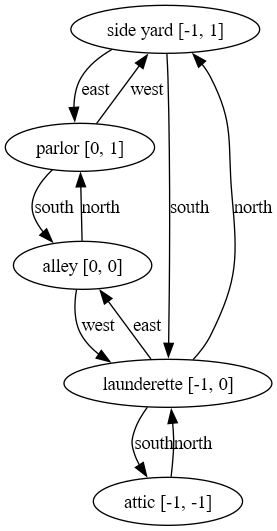

In [12]:
render_map(WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES)

This state space is rendered in the cell below - as this can sometimes take a long time to render, we've added a boolean flag that you can set to `False` to disable rendering the state space graph. The state space is also generally gigantic, so we also export it to a file for you to view. This is just for your viewing pleasure, and you do not need to view this rendering to complete the assignment.

In [13]:
render = False
if render:
    render_state_space(GRAPH, WORLD_STATE_HASH)

## State Space Search Helper Functions

You may find these functions useful when implementing your search algorithms in the TextWorld environment, but they are not necessary to use. 

`make_world_state()` takes a text observation and inventory information and constructs a state dictionary. `update_world_state()` takes a state dictionary and new observation text and new inventory text and returns an updated state dictionary.

In [14]:
def update_world_state(old_world_state: dict, new_observation: str, new_inventory: list) -> dict:
    """
    Update an existing state dictionary with new observation and inventory data.

    This function assumes that nothing changes other than with the new observation
    and inventory. It retrieves the new location from the observation, makes a deep
    copy of the old state dictionary, updates the location and inventory, parses the
    current room, and updates the door information based on the new observation.

    Args:
        old_world_state (dict): The existing state dictionary to be updated.
        new_observation (str): The new observation text from the environment.
        new_inventory (list): The new inventory list from the environment.

    Returns:
        dict: The updated state dictionary reflecting the new observation and inventory.
    """
    new_location = obs_location(new_observation)
    new_world_state = copy.deepcopy(old_world_state)
    new_world_state['location'] = new_location
    new_world_state['inventory'] = new_inventory
    new_world_state['rooms'][new_location] = parse_room(new_observation)
    doors = parse_doors(new_observation, new_location)
    for door, status in doors:
        new_world_state['doors'][door] = status
    return new_world_state

The following are custom functions for resetting the environment and executing actions during state space search. **Use these instead of `ENV.step()` and `ENV.reset()`.**

`do_action_state_search()` is a wrapper for `ENV.step()` that processes the output into a state dictionary. Pass in the string indicating the action (e.g., `'move north'`), and a reference to the environment object. This function returns a dictionary containing: state id, state observation, agent inventory, and list of valid actions.

`reset_state_search()` is a wrapper for `ENV.reset()` that processes the output into a state dictionary. Pass in the environment object. This function returns
a dictionary containing: state id, state observation, inventory, list of valid actions, and a state dictionary.

In [15]:
def do_action_state_search(action: str, env: TextWorldExpressEnv) -> dict:
    """
    Execute the action for state space search.

    This function returns the id of the new state, an observation, inventory,
    and list of valid actions.

    Args:
        action (str): The action to be executed in the environment.
        env (TextWorldExpressEnv): The environment instance from TextWorld.

    Returns:
        dict: A dictionary containing the new state id, observation, inventory,
              and valid actions.
    """
    _, _, _, infos = env.step(action)
    inv = infos['inventory']
    modified_obs = obs_with_inventory(infos['look'], inv)
    valid_actions = infos['validActions']
    valid_actions.remove('inventory')
    valid_actions.remove('look around')
    return {'id': hash_state(modified_obs),
            'observation': modified_obs,
            'inventory': parse_inventory(inv),
            'valid actions': valid_actions}

def state_dict_to_id(state: dict) -> str:
    """
    Convert a state dictionary to an id.

    Args:
        state (dict): The state dictionary to convert.

    Returns:
        str: The id corresponding to the state dictionary.
    """
    return list(WORLD_STATE_HASH.keys())[list(WORLD_STATE_HASH.values()).index(state)]

def reset_state_search(env: TextWorldExpressEnv, world_map_observations: list) -> dict:
    """
    Reset the environment for state space.

    This function returns initial state information as a dictionary containing,
    state id, observation, inventory, valid actions, and state dictionary.

    Args:
        env (TextWorldExpressEnv): The environment instance from TextWorld.
        world_map_observations (list): Observations of the world map.

    Returns:
        dict: A dictionary containing the initial state id, observation,
              inventory, valid actions, and state dictionary.
    """
    # Reset environment
    _, infos = env.reset(seed=SEED, gameFold="train", generateGoldPath=True)
    inv = infos['inventory']
    modified_obs = obs_with_inventory(infos['look'], inv)
    valid_actions = infos['validActions']
    valid_actions.remove('inventory')
    valid_actions.remove('look around')
    init_world_state = make_world_state(modified_obs,
                                        parse_inventory(inv),
                                        world_map_observations)
    id = state_dict_to_id(init_world_state)
    return {'id': id,
            'observation': modified_obs,
            'inventory': parse_inventory(inv),
            'valid actions': valid_actions,
            'state': init_world_state}

# Goal State Functions

**TODO:** Implement the `is_goal()` function for the Coin Game and Map Reader games. The `is_goal()` functions take in a state, as a hash ID (a string). These methods are only going to be used in your own solution code below, and we will not be checking this function for correctness (though if it is incorrect it will cause your solutions to fail!).

For the goal state functions, you are allowed to access the following global variables: `GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES`.

If you're unsure how to implement the `is_goal()` functions, you should look at the data structures and information provided above to understand how to access the relevant information you need, and you should play around with the environment to understand what the goal states look like!

In [16]:
# export - DO NOT MODIFY OR MOVE THIS LINE


def is_goal_coin(state: str) -> bool:
    is_goal = False
    ### YOUR CODE BELOW HERE ###
    state_info = WORLD_STATE_HASH[state]
    inventory = state_info.get("inventory", "empty")
    if inventory.lower() != "empty" and "coin" in inventory.lower():
        is_goal = True
    ### YOUR CODE ABOVE HERE ###
    return is_goal 

In [17]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def is_goal_mapreader(state: str) -> bool:
    is_goal = False
    ### YOUR CODE BELOW HERE ###
    state_info = WORLD_STATE_HASH[state]
    
    # Determine the starting location by looking for the room with coordinates (0, 0).
    starting_location = None
    for room, info in state_info.get("rooms", {}).items():
        things = info.get("things", [])
        for thing in things:
            # Check if the thing is represented as a list (i.e., has an attribute)
            if isinstance(thing, list):
                name = thing[0].lower()
                if "box" in name:
                    starting_location = room
                    break
        if starting_location is not None:
            break
    
    # For the goal to be satisfied, the coin should no longer be in the inventory.
    # (In Map Reader, the coin should have been returned to a box.)
    inventory = state_info.get("inventory", "empty").lower()
    if "coin" in inventory:
        # Coin is still with the agent.
        return False
    
    # Now, check the room at the starting location.
    # We expect the starting room (in the state's "rooms") to have a box
    # that now "contains a coin."
    room_info = state_info.get("rooms", {}).get(starting_location, {})
    things = room_info.get("things", [])
    
    for thing in things:
        # We assume that if an object has an attribute, it will be a list,
        # for example: ['a box', 'contains a coin']
        if isinstance(thing, list):
            name, attribute = thing[0].lower(), thing[1].lower()
            if "box" in name and "coin" in attribute:
                is_goal = True
                break
    ### YOUR CODE ABOVE HERE ###
    return is_goal

# Successor Function

**TODO:** Implement `get_successors()`. The function takes a state, as a hash ID (a string), and returns its successors and the action needed to reach the successor. You may store this information however you'd like, but the function should return a list. We will not directly test this function, but it will be used in your search algorithms below, so it must be implemented correctly!

For this function, you are allowed to access the following global variables: `GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES`.

In [18]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def get_successors(state: str) -> list:
    successors = []
    ### YOUR CODE BELOW HERE ###
    for parent, child, action in GRAPH:
        if parent == state:
            successors.append((child, action))
    ### YOUR CODE ABOVE HERE ###
    return successors

# Breadth-First Search (BFS)

**TODO:** Implement BFS. The function takes the following parameters:

- `init_state_info`: the structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions. This is provided by `reset_state_search()`, for example:
    ```python
    {'id': '1234567890',
    'observation': 'You are by the lecture hall. You\'re listening to the professor lecture (he\'s droning on and on and on). You\'d rather be implementing BFS right about now. You\'re close to figuring out the correct implementation, but you\'re not quite there yet. Maybe you are there. Who knows? Hopefully you!',
    'inventory': 'a coin',
    'valid actions': ['move north', 'move south'],
    'state': {'location': 'kitchen',
            'inventory': 'a coin',
            'rooms': {'living room': {'things': ['a box']},
                        'kitchen': {'things': []}}
            }
    }
    ```
- `graph`: a list of state transitions (i.e., `GRAPH`)
- `world_state_hash`: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- `is_goal`: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin_game` or `is_goal_map_reader`).

The function returns the following:
- `the_plan`: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- `visited_states`: A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_m]`. The states should be represented as state IDs (strings). Note that the length of `visited_states` might not necessarily be the same length as `the_plan`. 

**Important Notes:**
- You should **only** use the parameters provided to the function to implement your solution. You are welcome to use the helper functions provided above to help you implement your solution. Your solution should be efficient in terms of time and space - you should not be storing excess information in your search, nor should you be visiting the same state multiple times.
- For your implementation, you should **not** terminate if you find the goal state in the successor function when expanding the search. You should only terminate when you visit the goal state in the search algorithm. While many search algorithms can terminate upon finding a goal state when expanding successors, we are requiring that you expand all nodes in the search to ensure that all solutions return the same path when expanding successors. As such, you should only terminate when you visit the goal state in the search algorithm. 

In [19]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def bfs(init_state_info: dict, graph: list[tuple[str, str, str]], world_state_hash: dict, is_goal: callable) -> tuple[list[str], list[str]]:
    the_plan = []
    visited_states = []
    ### YOUR CODE BELOW HERE ###
    queue = deque()
    parent_map = {}  # Maps state id -> (parent_state_id, action_from_parent)

    start_state = init_state_info['id']
    queue.append(start_state)
    parent_map[start_state] = (None, None)  # Start has no parent
    
    goal_state = None
    
    # Begin BFS.
    while queue:
        current_state = queue.popleft()
        visited_states.append(current_state)
        
        # Only check for the goal when a state is popped (visited).
        if is_goal(current_state):
            goal_state = current_state
            break
        
        # Get the successors using the provided get_successors() function.
        for child_state, action in get_successors(current_state):
            # Ensure we don't revisit states.
            if child_state not in parent_map:
                parent_map[child_state] = (current_state, action)
                queue.append(child_state)
    
    # Reconstruct the plan (list of actions) from the start to the goal.
    if goal_state is not None:
        actions = []
        state = goal_state
        while parent_map[state][0] is not None:
            parent, action = parent_map[state]
            actions.append(action)
            state = parent
        the_plan = actions[::-1]  # Reverse the list to get the correct order from start to goal.
    ### YOUR CODE ABOVE HERE ###
    return the_plan, visited_states

Test BFS using the game environment loaded in earlier in the notebook

In [20]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
plan, visited = bfs(init_state_info, GRAPH, WORLD_STATE_HASH, is_goal = is_goal_coin if GAME_TYPE=="coin" else is_goal_mapreader)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['move north', 'move west', 'take coin', 'move east', 'move south', 'put coin in box']
Number of visited states: 19


# Depth-First Search (DFS)

**TODO:** Implement DFS. The function takes the following parameters:

- `init_state_info`: the data structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions.
- `graph`: a list of state transitions (i.e., `GRAPH`)
- `world_state_hash`: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- `is_goal`: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin_game` or `is_goal_map_reader`).

The function returns the following:
- `the_plan`: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- `visited_states`: A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_m]`. The states should be represented as state IDs (strings). Note that the length of `visited_states` might not necessarily be the same length as `the_plan`. 

**Important Notes:** 
- You should **only** use the parameters provided to the function to implement your solution. You are welcome to use the helper functions provided above to help you implement your solution. Your solution should be efficient in terms of time and space - you should not be storing excess information in your search, nor should you be visiting the same state multiple times.
- For your implementation, you should **not** terminate if you find the goal state in the successor function when expanding the search. You should only terminate when you visit the goal state in the search algorithm. While many search algorithms can terminate upon finding a goal state when expanding successors, we are requiring that you expand all nodes in the search to ensure that all solutions return the same path when expanding successors. As such, you should only terminate when you visit the goal state in the search algorithm. 
- When implementing DFS, please visit neighbors in the ***reverse*** order of the neighbors as they are presented in `GRAPH`. For example, if the neighbors of a vertex in `GRAPH` were `['A', 'B', 'C']`, please visit them as `C` -> `B` -> `A`. If you are using a ***stack*** in your implementation (i.e., you are implementing DFS iteratively), adding the neighbors in the given order to the stack will naturally have you visit them in reverse order, so you do not need to reverse the order manually (_this is a good exercise to think about_). 

In [21]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def dfs(init_state_info: dict, graph: list[tuple[str, str, str]], world_state_hash: dict, is_goal: callable) -> tuple[list[str], list[str]]:
    the_plan = []
    visited_states = []
    ### YOUR CODE BELOW HERE ###
    stack = [(init_state_info['id'], [])]
    visited_set = set()
    
    goal_path = None  # Store path when goal is found
    
    while stack:
        current_state, path = stack.pop()

        # Mark visited only after popping
        if current_state in visited_set:
            continue
        visited_set.add(current_state)
        visited_states.append(current_state)

        # Check if this state is a goal
        if is_goal(current_state):
            goal_path = path  # Store the path to goal
            break

        # Expand successors in correct order
        for child_state, action in get_successors(current_state):
            if child_state not in visited_set:
                stack.append((child_state, path + [action]))  # Append full path

    # Return the computed path and visited states
    if goal_path is not None:
        the_plan = goal_path
    ### YOUR CODE ABOVE HERE ###
    return the_plan, visited_states

Test DFS using the game environment loaded in earlier in the notebook:

In [22]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
plan, visited = dfs(init_state_info, GRAPH, WORLD_STATE_HASH, is_goal = is_goal_coin if GAME_TYPE=="coin" else is_goal_mapreader)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['put map in box', 'move north', 'move west', 'take coin', 'move south', 'move east', 'put coin in box']
Number of visited states: 11


# Heuristic Functions

Heuristics are functions that estimate the cost or distance from a given state to the goal state in search algorithms. They play a crucial role in informed search strategies, such as A* and greedy best-first search, by guiding the search process towards the most promising paths. The importance of heuristics lies in their ability to reduce the search space and improve efficiency. By providing an estimate of the remaining cost to reach the goal, heuristics help prioritize which nodes to explore first, potentially leading to faster solutions. 

A well-designed heuristic can significantly enhance the performance of an algorithm, making it more effective in finding optimal or near-optimal solutions. Conversely, a poor heuristic may lead to increased computation time and suboptimal paths. In the context of the Coin and Map Reader games, implementing effective heuristic functions can help the search algorithm navigate the environment more intelligently, ultimately resulting in quicker and more efficient gameplay.

**TODO:** Implement heuristic functions for the Coin and Map Reader games. The heuristic functions take a state as input (represented as a state ID, a string), and returns a floating point value, which is the estimated distance to the goal.

For this function, you are allowed to access and use the following global variables: `GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES`.

**Tips:**
- Think about what information tells you that you are at the goal state, and what the requirements for both games are.
- What data structure can you use to determine the distance from the current state to the goal state?
- There are many ways to implement a heuristic function, and the effectiveness of a heuristic can vary depending on the problem. You may need to experiment with different heuristics to find the most effective one for each game!

In [23]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def h_coin(state: str) -> float:
    h_value = 0.0
    ### YOUR CODE BELOW HERE ###
    state_info = WORLD_STATE_HASH[state]
    agent_location = state_info["location"]
    
    # If the agent already has the coin, heuristic is 0 (goal reached)
    inventory = state_info.get("inventory", "empty").lower()
    if "coin" in inventory:
        return 0.0
    
    # Find where the coin is located
    coin_location = None
    for room, room_data in state_info.get("rooms", {}).items():
        for obj in room_data.get("things", []):
            if isinstance(obj, str) and "coin" in obj.lower():
                coin_location = room
                break
        if coin_location:
            break

    if not coin_location:
        # If the coin is not in any room, assume max distance
        return float('inf')

    # Use BFS to estimate shortest path distance
    queue = deque([(agent_location, 0)])  # (location, distance)
    visited = set()

    while queue:
        current_location, dist = queue.popleft()
        if current_location in visited:
            continue
        visited.add(current_location)

        # If we reach the coin's location, return the distance as heuristic
        if current_location == coin_location:
            return float(dist)

        # Expand neighbors from WORLD_MAP
        for loc1, action, loc2 in WORLD_MAP:
            if loc1 == current_location and loc2 not in visited:
                queue.append((loc2, dist + 1))
            elif loc2 == current_location and loc1 not in visited:
                queue.append((loc1, dist + 1))

    # If no path is found, assume a very high cost
    h_value = float('inf')
    ### YOUR CODE ABOVE HERE ###
    return h_value

In [24]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def h_mapreader(state: str) -> float:
    h_value = 0.0
    ### YOUR CODE BELOW HERE ###
    # Retrieve the current state information
    state_info = WORLD_STATE_HASH[state]
    agent_location = state_info["location"]

    # If the agent already has the coin, we only need to go to the box
    inventory = state_info.get("inventory", "empty").lower()
    has_coin = "coin" in inventory

    # Find the coin location
    coin_location = None
    box_location = None

    for room, room_data in state_info.get("rooms", {}).items():
        for obj in room_data.get("things", []):
            if isinstance(obj, str) and "coin" in obj.lower():
                coin_location = room
            if isinstance(obj, list) and "box" in obj[0].lower():
                box_location = room
        if coin_location and box_location:
            break  # Stop early if both are found

    # 🚨 NEW: If this state is already a goal state, return 0.0 immediately
    if is_goal_mapreader(state):
        return 0.0

    if not box_location:
        return float('inf')  # If no box is found, return high cost

    # BFS function to calculate the shortest path between two locations
    def bfs_distance(start, target):
        if start == target:
            return 0
        queue = deque([(start, 0)])
        visited = set()

        while queue:
            current_location, dist = queue.popleft()
            if current_location in visited:
                continue
            visited.add(current_location)

            if current_location == target:
                return float(dist)

            for loc1, action, loc2 in WORLD_MAP:
                if loc1 == current_location and loc2 not in visited:
                    queue.append((loc2, dist + 1))
                elif loc2 == current_location and loc1 not in visited:
                    queue.append((loc1, dist + 1))

        return float('inf')  # If no path is found, return a large value

    # Compute heuristic based on whether the agent has the coin
    if has_coin:
        h_value = bfs_distance(agent_location, box_location)  # Distance to the box
    else:
        if not coin_location:
            return float('inf')  # No coin found
        h_value = bfs_distance(agent_location, coin_location) + bfs_distance(coin_location, box_location)

    ### YOUR CODE ABOVE HERE ###
    return h_value

# A* Search

**TODO:** Implement A*. The function takes the following parameters:

- `init_state_info`: the data structure given by `reset_state_search()` containing state id, state dictionary, initial observation, initial inventory, and valid actions.
- `graph`: a list of state transitions (i.e., `GRAPH`)
- `world_state_hash`: a dictionary that maps world state ids to state dictionaries (i.e., `WORLD_STATE_HASH`)
- `is_goal`: a function that takes a state and returns True or False whether that state is a goal state (i.e., `is_goal_coin_game` or `is_goal_map_reader`).
- `h_func`: the heuristic function, takes a state and returns the estimated distance to the goal state (i.e., `h_coin` or `h_mapreader`).

The function returns the following:
- `the_plan`: a list of actions, e.g. `[action_string_1, action_string_2, ..., action_string_n]`
- `visited_states`: A list of all states visited during the search, e.g., `[state_1, state_2, ..., state_m]`. The states should be represented as state IDs (strings). Note that the length of `visited_states` might not necessarily be the same length as `the_plan`. 

**Important Notes:**
- The coin and mapreader graphs have uniform edge costs, so the cost of moving from one state to another is always some constant value. For your implementation purposes, you can assume that the cost of moving from one state to another is 1.
- Please break ties in the priority queue by going with lower state IDs first. For example, if you have two state IDs `1`, `2` with the same cost, choose `1` first since its state ID is lower. Since these state IDs are strings, please compare them as strings, not as integers. Do not use any other method for breaking ties."
- You should **only** use the parameters provided to the function to implement your solution. You are welcome to use the helper functions provided above to help you implement your solution. Your solution should be efficient in terms of time and space - you should not be storing excess information in your search, nor should you be visiting the same state multiple times.
- For your implementation, you should **not** terminate if you find the goal state in the successor function when expanding the search. You should only terminate when you visit the goal state in the search algorithm. While many search algorithms can terminate upon finding a goal state when expanding successors, we are requiring that you expand all nodes in the search to ensure that all solutions return the same path when expanding successors. As such, you should only terminate when you visit the goal state in the search algorithm. 

In [25]:
# export - DO NOT MODIFY OR MOVE THIS LINE

def a_star(init_state_info: dict, graph: list[tuple[str, str, str]], world_state_hash: dict, is_goal: callable, h_func: callable) -> tuple[list[str], list[str]]:
    the_plan = []
    visited_states = []

    ### YOUR CODE BELOW HERE ###
    visited_states = set(visited_states)
    g_costs = {}

    # Initialize the priority queue.
    # Each entry in the priority queue is a tuple: (f, state_id, g, plan)
    start_state = init_state_info['id']
    start_g = 0
    start_f = start_g + h_func(start_state)
    heapq.heappush(pq := [], (start_f, start_state, start_g, []))
    g_costs[start_state] = start_g

    goal_state = None

    while pq:
        # Pop the state with the smallest f (and, if tied, the lower state id)
        f, state, g, plan = heapq.heappop(pq)

        # Skip if we've already expanded this state.
        if state in visited_states:
            continue

        # Mark the state as visited.
        visited_states.add(state)
        the_plan.append(state)

        # Only terminate when the goal is popped.
        if is_goal(state):
            goal_state = state
            the_plan = plan
            break

        # Expand all successors.
        for child_state, action in get_successors(state):
            new_g = g + 1  # cost per step is 1
            new_f = new_g + h_func(child_state)
            # Only push this child if either we have never seen it or we found a better cost.
            if child_state not in g_costs or new_g < g_costs[child_state]:
                g_costs[child_state] = new_g
                # The tuple ordering here is (f, state, g, plan). When f values are equal,
                # Python compares state (a string) and thus lower state IDs come first.
                heapq.heappush(pq, (new_f, child_state, new_g, plan + [action]))

    ### YOUR CODE ABOVE HERE ###
    return the_plan, visited_states

Test A*

In [26]:
init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
plan, visited = a_star(init_state_info, GRAPH, WORLD_STATE_HASH,
                       h_func = h_coin if GAME_TYPE == "coin" else h_mapreader,
                       is_goal = is_goal_coin if GAME_TYPE == "coin" else is_goal_mapreader)
print('The plan:', plan)
print('Number of visited states:', len(visited))

The plan: ['move north', 'move west', 'take coin', 'move east', 'move south', 'put coin in box']
Number of visited states: 13


# Testing

## Generating Outputs For Each Search Algorithm 

Run all the environments that are in files in the file system. This produces a dictionary that relates game configuration (game type, game parameters, seed) to a tuple containing the plan and the visited states.

You should remove all print statements from your code before running the below cells, as it will make the output difficult to read.

In [27]:
def run_all_environments(algorithm: callable) -> dict:
    global GAME_TYPE, GAME_PARAMS, SEED
    global GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES
    files = os.listdir('environment_files/')
    results = {}
    for file in files:
        m = re.search(r'([a-z]+)\+([a-zA-Z0-9,=]+)\+seed\=([0-9]+).json', file)
        if m is not None and m.lastindex >= 3:
            GAME_TYPE = m[1]
            GAME_PARAMS = m[2]
            SEED = int(m[3])
            print(f'============ game={GAME_TYPE} params={GAME_PARAMS} seed={SEED} ============')
            GRAPH, WORLD_STATE_HASH, WORLD_OBSERVATION_HASH, WORLD_MAP, WORLD_MAP_OBSERVATIONS, COORDINATES = read_environment_file(GAME_TYPE, GAME_PARAMS, SEED)
            ENV.load(gameName=GAME_TYPE, gameParams=GAME_PARAMS)
            init_state_info = reset_state_search(ENV, WORLD_MAP_OBSERVATIONS)
            if algorithm.__name__ == 'a_star':
                plan, visited = algorithm(init_state_info, GRAPH, WORLD_STATE_HASH,
                                            is_goal = eval('is_goal_' + GAME_TYPE),
                                            h_func = eval('h_' + GAME_TYPE))
            else:
                plan, visited = algorithm(init_state_info, GRAPH, WORLD_STATE_HASH,
                            is_goal = eval('is_goal_' + GAME_TYPE))
        results[(GAME_TYPE, GAME_PARAMS, SEED)] = (plan, visited)
    for setting in results.keys():
        plan, visited = results[setting]
        if plan is None or visited is None or len(plan) == 0 or len(visited) == 0:
            print(f"{algorithm.__name__} did not produce a valid result for {setting}")
    return results

In [28]:
# BFS results
output_dir = 'student_outputs'
os.makedirs(output_dir, exist_ok=True)

results = run_all_environments(algorithm=bfs)
print(results)
with open(os.path.join(output_dir, 'bfs.txt'), 'w') as f:
    f.write(str(results))

============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=4 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=

In [29]:
# DFS results
output_dir = 'student_outputs'
os.makedirs(output_dir, exist_ok=True)

results = run_all_environments(algorithm=dfs)
print(results)
with open('student_outputs/dfs.txt', 'w') as f:
    f.write(str(results))

============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=4 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=

In [30]:
# A* results
output_dir = 'student_outputs'
os.makedirs(output_dir, exist_ok=True)

results = run_all_environments(algorithm=a_star)
print(results)
with open('student_outputs/a_star.txt', 'w') as f:
    f.write(str(results))

============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=10,includeDoors=1,numDistractorItems=0 seed=4 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=0 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=1 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=2 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=3 ============
============ game=coin params=numLocations=5,includeDoors=1,numDistractorItems=0 seed=

## Comparing Generated Results to Expected Outputs

The [expected outputs](expected_outputs/) directory contains the expected outputs for each search algorithm for each game configuration. We will compare the generated outputs from your `run_all_environments()` functions (now stored in the [student outputs](student_outputs/) directory) to the expected outputs to determine if your implementations meet our benchmarks.

We will be doing the same comparisons here as we will in the autograder (though we will be doing it in a more automated fashion, and test your code with more environments). This is a good litmus test for you to see how your code will perform in the autograder (since most of the environments we will test with are provided).

In [31]:
def evaluate_student_outputs(algorithm: str) -> None:
    with open(f'student_outputs/{algorithm}.txt', 'r') as f:
        student_solution = eval(f.read())

    with open(f'expected_outputs/{algorithm}.txt', 'r') as f:
        expected_solution = eval(f.read())

    failed_configs = set()
    for config in student_solution:

        student_path = student_solution[config][0]
        expected_path = expected_solution[config][0]
        student_visited_size = len(student_solution[config][1])
        expected_visited_size = len(expected_solution[config][1])

        path_incorrect = False
        vs_incorrect = False

        if student_visited_size > expected_visited_size:
            vs_incorrect = True
            failed_configs.add(config)
            print("Visited set sizes differed for " + str(config))
            print("\tstudent visited set size: " + str(student_visited_size))
            print("\texpected visited set size: " + str(expected_visited_size))

        if len(student_path) != len(expected_path):
            path_incorrect = True

        if not path_incorrect and not vs_incorrect:
            for i in range(len(student_path)):
                if student_path[i] != expected_path[i] and expected_path[i] in [
                    "take coin",
                    "put coin in box",
                ]:
                    path_incorrect = True
                    break

        if path_incorrect:
            print(f"Incorrect path for {config}")
            print(f"student path: {student_path}")
            print(f"expected path: {expected_path}")
            failed_configs.add(config)

    if len(failed_configs) == 0:
        print(f"Student implementation of {algorithm} succeeded for all provided configurations!")
        return 
    
    for config in student_solution:
        if config not in failed_configs:
            print(f"Student implementation of {algorithm} succeeded for {config}")

Modify the variable `ALGORITHM` below to test each of your search algorithms for all of the provided Coin Game and Map Reader Game configurations.

In [32]:
# set ALGORITHM TO "bfs", "dfs", or "a_star" to evaluate the your implementation
ALGORITHM = "a_star"
evaluate_student_outputs(ALGORITHM)

Student implementation of a_star succeeded for all provided configurations!


## Heuristic Admissibility & Consistency Checks

### Heuristic Admissibility Check

The following function evaluates whether your heuristic function is admissible. To do this, you will pass in your heuristic function. The function will return a boolean value indicating whether your heuristic is admissible. An admissible heuristic is one that never overestimates the cost to reach the goal. If your heuristic is admissible, the function will return `True`. If your heuristic is inadmissible, the function will return `False`.


In [33]:
def heuristic_admissibility_check(h_func: callable, is_goal: callable, key: callable = lambda state: state) -> bool:
    """
    Evaluates whether the provided heuristic function is admissible.

    An admissible heuristic is one that never overestimates the cost to reach the goal.
    This function checks the heuristic against all states in the environment and returns
    True if the heuristic is admissible, or False if it is inadmissible.

    Parameters:
    h_func (callable): The heuristic function to evaluate.
    is_goal (callable): A function that checks if a given state is a goal state.
    key (callable, optional): A function to transform the state representation. Defaults to the identity function.

    Returns:
    bool: True if the heuristic is admissible, False otherwise.
    """
    G = nx.DiGraph()
    for edge in GRAPH:
        G.add_edge(edge[0], edge[1], weight=1)
    
    goals = [node for node in G.nodes if is_goal(key(node))]
    
    if not goals:
        raise ValueError("No goal states found in the graph.")
    
    reverse_G = G.reverse()
    
    shortest_to_goal = nx.multi_source_dijkstra_path_length(reverse_G, sources=goals, weight="weight")
    
    for node in G.nodes:
        h_value = h_func(key(node))
        h_star = shortest_to_goal.get(node, float('inf'))
        if h_value > h_star:
            print("Inadmissible heuristic")
            print("State:", key(node))
            print("Heuristic value:", h_value, "Shortest path to goal:", h_star)
            return False
    
    return True

In [34]:
if GAME_TYPE == "coin":
    coin_admissibility = heuristic_admissibility_check(h_func=h_coin, is_goal=is_goal_coin)
    print(f"Coin Game Heuristic Admissibility: {coin_admissibility}")
else:
    mapreader_admissibility = heuristic_admissibility_check(h_func=h_mapreader, is_goal=is_goal_mapreader)
    print(f"Mapreader Game Headuristic Admissibility: {mapreader_admissibility}")

Mapreader Game Headuristic Admissibility: True


### Heuristic Consistency Check

The following function evaluates whether your heuristic function is consistent. To do this, you will pass in your heuristic function. The function will return a boolean value indicating whether your heuristic is consistent. A consistent heuristic is one that satisfies the triangle inequality. If your heuristic is consistent, the function will return `True`. If your heuristic is inconsistent, the function will return `False`.

In [35]:
def heuristic_consistency_check(h_func: callable, is_goal: callable, key: callable = lambda state: state) -> bool:
    """
    Evaluates whether the given heuristic function is consistent. A consistent heuristic satisfies the triangle inequality.

    Parameters:
    h_func (callable): The heuristic function to evaluate.
    is_goal (callable): A function that checks if a given state is a goal state.
    key (callable, optional): A function to transform the state representation. Defaults to the identity function.

    Returns:
    bool: True if the heuristic is consistent, False otherwise.
    """
    G = nx.DiGraph()
    for edge in GRAPH:
        G.add_edge(edge[0], edge[1], weight=1)

    goals = [node for node in G.nodes if is_goal(key(node))]
    
    if not goals:
        raise ValueError("No goal states found in the graph.")

    if any([h_func(key(node)) != 0 for node in goals]):
        print("Inconsistent heuristic: Goal states must have heuristic value of 0.")
        return False

    for u, v, data in G.edges(data=True):
        weight = data["weight"]
        h_u = h_func(key(u))
        h_v = h_func(key(v))
        
        if h_u > h_v + weight:
            print("Inconsistent heuristic")
            print(f"State {key(u)} (h: {h_u}) and State {key(v)} (h: {h_v})")
            print(f"Edge weight: {weight}")
            return False

    return True

In [36]:
if GAME_TYPE == "coin":
    coin_consistency = heuristic_consistency_check(h_func=h_coin, is_goal=is_goal_coin)
    print(f"Coin Game Consistency: {coin_consistency}")
else:
    mapreader_consistency = heuristic_consistency_check(h_func=h_mapreader, is_goal=is_goal_mapreader)
    print(f"Mapreader Game Consistency: {mapreader_consistency}")

Mapreader Game Consistency: True


# Grading

Grading will consist of testing all provided game configurations on BFS, DFS, and A*. We will _also_ test your algorithms on hidden configurations of coin game and map reader game. Rest assured, these configurations do **NOT** have any invalid game settings or edge cases that you must consider (i.e., there will ALWAYS be a path to the goal, there will always be a start state, etc.). We are simply testing your code further to ensure that no cases are hardcoded. 

Your heuristics will be tested for admissibility and consistency as well. Your heuristic must be admissible and consistent for each environment, for each game type (no partial credit will be awarded).

## Rubric
- 0.5 point for each correct plan in the _provided_ game configurations, per algorithm, based on the provided instructions (60 points).
- 0.5 point for each correct plan in the _hidden_ game configurations, per algorithm, based on the provided instructions (30 points).
- 2.5 points for admissible heuristic for each of the two game types (5 points).
- 2.5 points for consistency heuristic for each of the two game types (5 points).
- -0.1 point deduction for each 10% difference between the number of visited states and the set threshold of expected visited states.

**Maximum total points: 100**

## Important Details
Grading will be conducted by comparing your plans and number of visited states to our rubric. We will add cells to your notebook at grading time to load and test our hidden world configuration files. 

The autograder will display "sanity check" results to help you verify that your code behaves the same in the autograder as it does locally. These tests are a subset of the full autograder, and will test the some of the same configurations that we have provided. It is your responsibility to test your code and verify its correctness, and you should use the provided resources to do so. 

We will also inspect the entire notebook to check if your algorithm implementations include details that are inconsistent with the assignment (e.g., hard-coding values or actions to pass tests) and to make sure no cells were altered to provide unearned grading results. Doing so will result in a grade of 0 for the entire assignment, and may be reported to the Office of Student Integrity.

Your submissions are also subject to plagiarism checks - as a reminder, all code must be written by yourself, and no one else (classmates, excessive internet resources, LLMs, etc.). You are permitted to use course resources to help you complete the assignment. Any violations of this will receive a 0 and may be reported to the Office of Student Integrity for further investigation. 

# Submission Instructions

Upload this notebook with the name `submission.ipynb` file to Gradescope. The autograder will **only** run successfully if your file is named this way. You must ensure that you have removed all print statements from **your** code, or the autograder may fail to run. Excessive print statements will also result in muddled test case outputs, which makes it more difficult to interpret your score. 

We've added appropriate comments to the top of certain cells for the autograder to export (`# export`). You do NOT have to do anything (e.g. remove print statements) to cells we have provided - anything related to those have been handled for you. You are responsible for ensuring your own code has no syntax errors or unnecessary print statements. You ***CANNOT*** modify the export comments at the top of the cells, or the autograder will fail to run on your submission.

You should ***not*** add any cells that your code requires to the notebook when submitting. You're welcome to add any code as you need to extra cells when testing, but they will not be graded. Only the provided cells will be graded. As mentioned in the top of the notebook, **any helper functions that you add should be nested within the function that uses them.**

If you encounter any issues with the autograder, please feel free to make a post on Ed Discussion. We highly recommend making a public post to clarify any questions, as it's likely that other students have the same questions as you! If you have a question that needs to be private, please make a private post.